In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import anderson
import statsmodels.api as sm

#Загрузим данные из файлов с контрольной и тестовой группой

In [73]:
from pandas.io.parsers.readers import read_csv
test = read_csv("/content/test_group.csv")
control = read_csv("/content/control_group.csv")

#Проверим данные


In [74]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     object
 1   Date                 30 non-null     object
 2   Spend [USD]          30 non-null     int64 
 3   # of Impressions     30 non-null     int64 
 4   Reach                30 non-null     int64 
 5   # of Website Clicks  30 non-null     int64 
 6   # of Searches        30 non-null     int64 
 7   # of View Content    30 non-null     int64 
 8   # of Add to Cart     30 non-null     int64 
 9   # of Purchase        30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


In [76]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


#Видим, что в контрольной группе есть nan,в последующим заполним их средним значением для удобства.



#Мы решили что нашей основной метрикой будет CTR(т.к. в условие сказано новый расчет цены за переход), прокси метриками мы возьмем Customer Acqusition Cost и конверсия в целевое действие - покупку.
#Общая гипотеза: Мы предпологаем, что модель ставок "Средняя ставка" эффективнее "Максимальная ставка", с точки зрения CTR
### В нашем исследовании мы будем использовать:
###1.Уровень значимости (ошибки I рода) мы принимаем за 0,05. Уровень той ошибки, которая будет связано с тем, что мы можем найти то, что действительно не существует.
###2.Ошибка II рода будет равна 0,2.
###3.Соотвественно мощность теста будет равна 0,8.
###4. MDE = 1.82 %
###5. n = 902 753 (в каждой группе)
###6. Время проведения А/Б - теста 18 дней ( При учете, что примерно в день ~ 10**5 клиентов)

In [53]:
ctr_control = control[ :18]["# of Website Clicks"] / control[ :18]["# of Impressions"]
ctr_control = ctr_control.fillna(ctr_control.mean())
ctr_control

0     0.084835
1     0.067003
2     0.049411
3     0.042057
4     0.052237
5     0.036928
6     0.018575
7     0.079834
8     0.051083
9     0.019358
10    0.070605
11    0.025660
12    0.079110
13    0.031126
14    0.036855
15    0.073295
16    0.055413
17    0.066878
dtype: float64

In [ ]:
ctr_test = test[ :18]["# of Website Clicks"] / test[ :18]["# of Impressions"]
ctr_test.mean()

#Исследуем распределение в наших группах(CTR):

In [ ]:
ctr_test.describe()

(array([0., 0., 5., 5., 2., 2., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38]),
 <BarContainer object of 19 artists>)

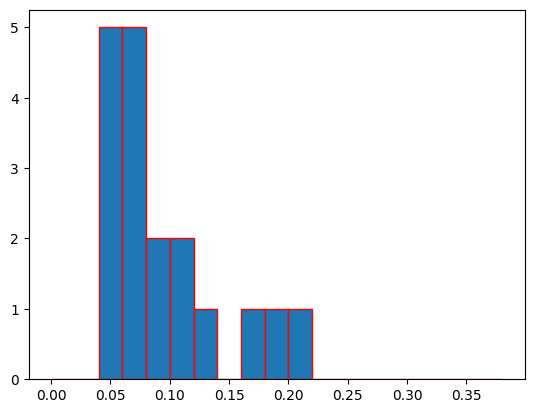

In [25]:
bin_ranges = [0.02*i for i in range(20)]
plt.hist (ctr_test, bins= bin_ranges, edgecolor='red')

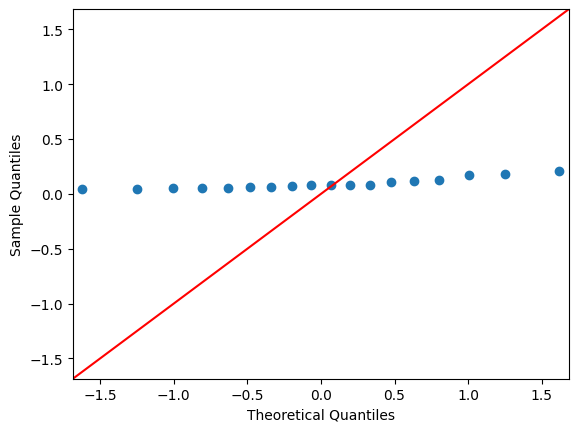

In [26]:
fig = sm.qqplot(ctr_test, line='45')
plt.show()

In [11]:
shapiro(ctr_test)

ShapiroResult(statistic=0.8433228731155396, pvalue=0.006657373625785112)

##Судя по гистограмме,qqplot и тесту Шапиро-Уилка, мы можем утверждать, что в тестовой группе не нормальное распределение.

In [ ]:
ctr_control.describe()

(array([0., 2., 1., 3., 2., 3., 2., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
 <BarContainer object of 19 artists>)

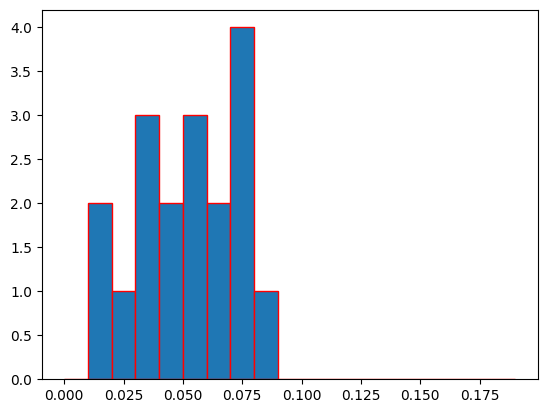

In [14]:
bin_ranges = [0.01*i for i in range(20)]
plt.hist (ctr_control, bins= bin_ranges, edgecolor='red')

In [27]:
anderson(ctr_control)

AndersonResult(statistic=0.29005763893629677, critical_values=array([0.503, 0.573, 0.687, 0.802, 0.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.052236741483540926, scale=0.021309485411318687)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [28]:
shapiro(ctr_control)

ShapiroResult(statistic=0.9488298892974854, pvalue=0.4069572389125824)

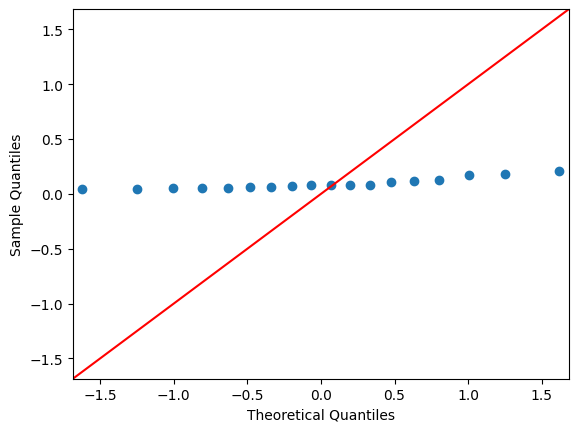

In [22]:
fig = sm.qqplot(ctr_test, line='45')
plt.show()

##Несмотря на то, что статистический критерии на проверку нормальности распределения в выборке утверждают, что распределение нормальное, qqplot говорит об обратном явлении.

##Учитывая, что мы имеем дело с 2-мя выборками с ненормальным распределением воспользуемся непараметрическим критерием Манна-Уитни.

In [18]:
mannwhitneyu(ctr_control, ctr_test, alternative='two-sided')

MannwhitneyuResult(statistic=72.0, pvalue=0.004630782857362428)

##Судя по тесту Манна-Уитни, мы отклоняем нулевую гипотезу и утверждаем, что выборки статистически различимы.

In [49]:
num_samples = 10000

bootstrap_means = np.zeros(num_samples)

# Perform bootstrap sampling
for i in range(num_samples):
    bootstrap_sample = np.random.choice(ctr_test, size=len(ctr_test), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means[i] = bootstrap_mean

confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print("95% доверительный интервал:", confidence_interval)

95% доверительный интервал: [0.07323621 0.11823628]


In [50]:
ctr_control.mean()

0.052236741483540926

In [51]:
ctr_test.mean()

0.09441009061269336

##Исходя из того, что выборки статистически различимы, мы решили построить на основе тестовой выборки 95-% доверительный интервал, чтобы предположить как CTR измениться на всей генеральной совокупности.

##Далее посчитаем CAC

In [87]:
cac_control = control[ :18]["Spend [USD]"] / control[ :18]["# of Impressions"]
cac_control = ctr_control.fillna(cac_control.mean())
cac_control.mean()

0.052236741483540926

In [88]:
cac_test = test[ :18]["Spend [USD]"] / test[ :18]["# of Impressions"]
ctr_test = ctr_test.fillna(ctr_test.mean())
cac_test.mean()

0.03964547014919223

#Исследуем распределение в наших группах(CAC):

(array([0., 0., 9., 3., 1., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
 <BarContainer object of 19 artists>)

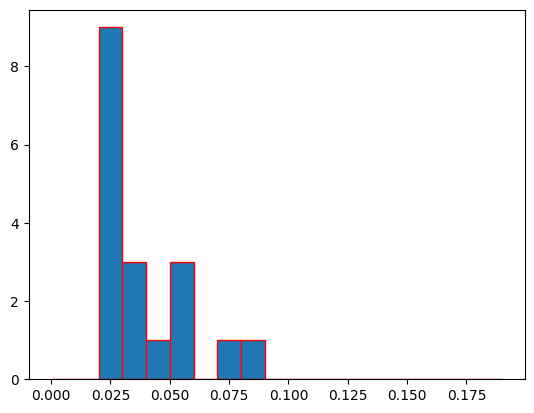

In [65]:
bin_ranges = [0.01*i for i in range(20)]
plt.hist (cac_test, bins= bin_ranges, edgecolor='red')

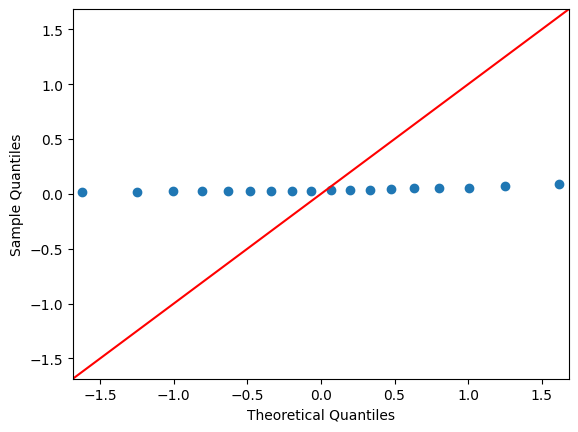

In [66]:
fig = sm.qqplot(cac_test, line='45')
plt.show()

In [67]:
shapiro(cac_test)

ShapiroResult(statistic=0.8502678871154785, pvalue=0.008551505394279957)

##Тщательно изучив графики распределения и использовав тест Шапиро-Уилка, мы не можем принять нулевую гипотезу о нормальности распределении данных в тестовой выборке.

(array([0., 8., 8., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 <BarContainer object of 24 artists>)

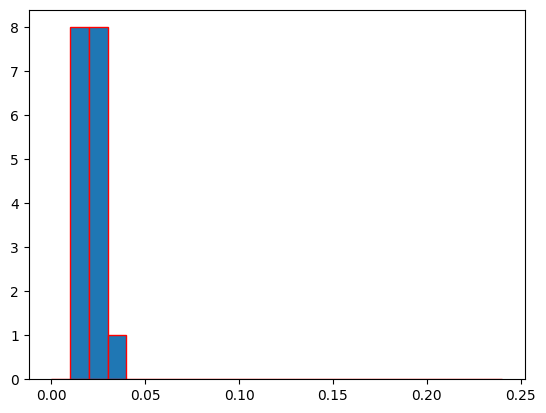

In [70]:
bin_ranges = [0.01*i for i in range(25)]
plt.hist (cac_control, bins= bin_ranges, edgecolor='red')

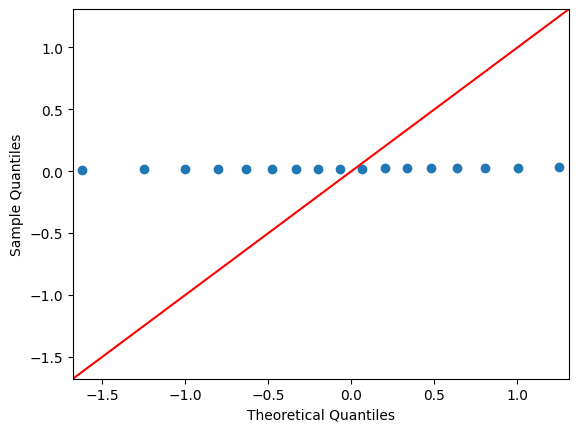

In [71]:
fig = sm.qqplot(cac_control, line='45')
plt.show()

In [83]:
shapiro(cac_test)

ShapiroResult(statistic=0.8502678871154785, pvalue=0.008551505394279957)

##Тщательно изучив графики распределения и использовав тест Шапиро-Уилка, мы не можем принять нулевую гипотезу о нормальности распределении данных в контрольной выборке.

##Учитывая, что мы не можем утверждать, что наши выборки нормально распределены, воспользовались критерием Манна-Уитни.

In [89]:
mannwhitneyu(cac_control, cac_test, alternative='two-sided')

MannwhitneyuResult(statistic=216.0, pvalue=0.0905192333421713)

In [90]:
num_samples = 10000

bootstrap_diffs = np.zeros(num_samples)

for i in range(num_samples):
    bootstrap_group1 = np.random.choice(cac_test, size=len(cac_test), replace=True)
    bootstrap_group2 = np.random.choice(ctr_test, size=len(ctr_test), replace=True)

    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

p_value = np.mean(bootstrap_diffs >= np.mean(cac_test) - np.mean(cac_control))

print("Bootstrap p-value:", p_value)

Bootstrap p-value: 0.0001


## Т.К. Манна-Уитни показала не очень большое pvalue, решили проверить при помощи бустрепа. Он показал, что мы должны отклонить нулевую гипотезу о равенстве средних значений.

In [91]:
num_samples = 10000

bootstrap_means = np.zeros(num_samples)

# Perform bootstrap sampling
for i in range(num_samples):
    bootstrap_sample = np.random.choice(cac_test, size=len(cac_test), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means[i] = bootstrap_mean

confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print("95% доверительный интервал:", confidence_interval)

95% доверительный интервал: [0.03149407 0.04890822]


##На основе бустрепа построили 95-% доверительный интервал на основе тестовой выборки.

##Теперь посчитаем конверсию в целевое действие(в покупку) и проанализируем выборки.

In [101]:
cv_test = test[:18]["# of Purchase"] / test[:18]["# of Impressions"]
cv_test = cv_test.fillna(cv_test.mean())
cv_test.mean()

0.007930202097061264

In [112]:
cv_control = control[:18]["# of Purchase"] / control[:18]["# of Impressions"]
cv_control = cv_control.fillna(cv_control.mean())
cv_control.mean()

0.004926246614397287

In [103]:
shapiro(cv_test)

ShapiroResult(statistic=0.8863528370857239, pvalue=0.033435121178627014)

(array([0., 0., 2., 0., 4., 1., 4., 1., 1.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009]),
 <BarContainer object of 9 artists>)

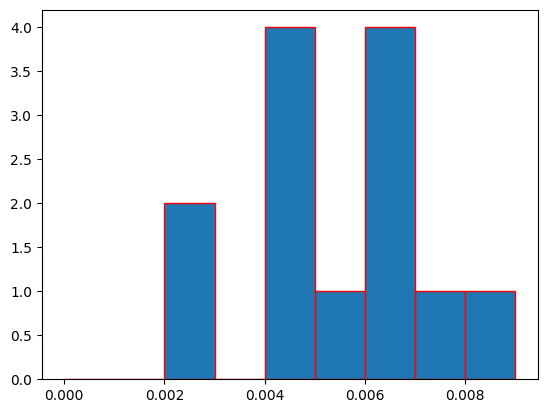

In [106]:
bin_ranges = [0.001*i for i in range(10)]
plt.hist (cv_test, bins= bin_ranges, edgecolor='red')

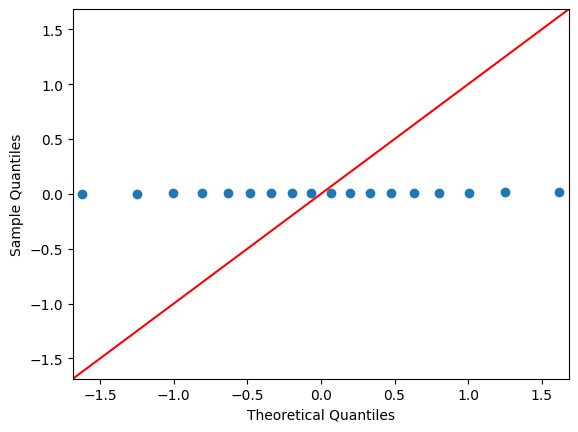

In [107]:
fig = sm.qqplot(cv_test, line='45')
plt.show()

##Судя по тесту Шапиро-Уилка, гистограмме и qqplot, мы не можем принять нулевую гипотезу о нормальности распределения тестовой группы.

In [108]:
shapiro(cv_control)

ShapiroResult(statistic=0.9584903717041016, pvalue=0.2832922339439392)

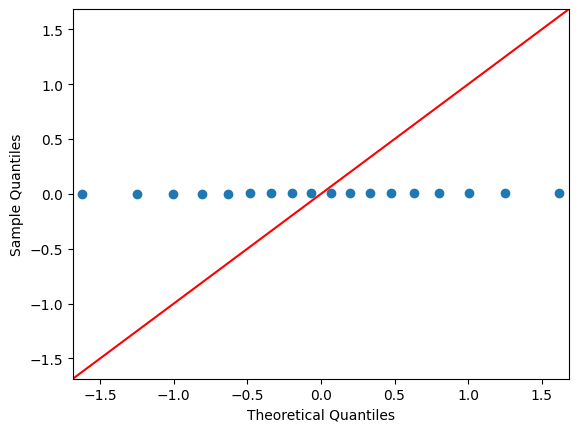

In [113]:
fig = sm.qqplot(cv_control, line='45')
plt.show()

(array([0., 0., 0., 1., 1., 2., 0., 1., 3., 2., 2., 0., 2., 1., 2., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
        0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
        0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
        0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145]),
 <BarContainer object of 29 artists>)

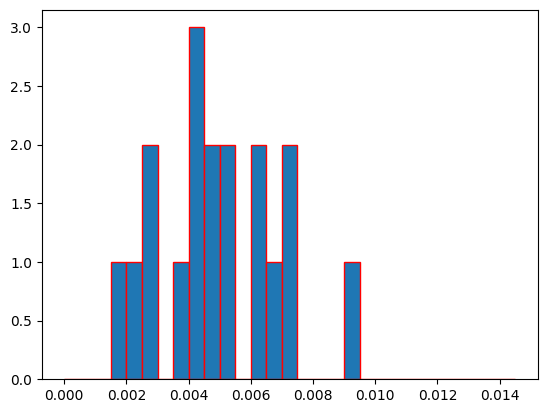

In [122]:
bin_ranges = [0.0005*i for i in range(30)]
plt.hist (cv_control, bins= bin_ranges, edgecolor='red')

In [117]:
anderson(cv_control)

AndersonResult(statistic=0.1593162798515344, critical_values=array([0.503, 0.573, 0.687, 0.802, 0.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.004926246614397287, scale=0.001971962061512483)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

## Исходя из выше описанного и сказанного, мы решили не принимать нулевую гипотезу о нормальности распределения в контрольной группе.

In [123]:
mannwhitneyu(cv_control, cv_test)

MannwhitneyuResult(statistic=96.0, pvalue=0.03823483580600874)

In [125]:
num_samples = 10000

bootstrap_diffs = np.zeros(num_samples)

for i in range(num_samples):
    bootstrap_group1 = np.random.choice(cv_test, size=len(cv_test), replace=True)
    bootstrap_group2 = np.random.choice(cv_test, size=len(cv_test), replace=True)

    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

p_value = np.mean(bootstrap_diffs >= np.mean(cv_test) - np.mean(cv_control))

print("Bootstrap p-value:", p_value)

Bootstrap p-value: 0.0213


Бустреп и Манна-Уитни показали, что различия между тестовой и контрольной выборкой статистической значимы.

In [124]:
num_samples = 10000

bootstrap_means = np.zeros(num_samples)

# Perform bootstrap sampling
for i in range(num_samples):
    bootstrap_sample = np.random.choice(cv_test, size=len(cv_test), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means[i] = bootstrap_mean

confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print("95% доверительный интервал:", confidence_interval)

95% доверительный интервал: [0.00603135 0.01012116]


##Построил доверительный 95-% интервал на основе тестовой выборки.

###Сейчас мы можем сделать следующие выводы:
**-Модель ставок "Средняя ставка" эффективнее модели "Максимальная ставка" т.к. среднее значение(тестовой группы) находится в доверительном 95-% интервале ("Средняя"), который больше чем среднее значение контрольной.
-Прокси метрики статистически отличаются и их 95-% доверительные интервалы и их средние значения находится выше чем уровень в контрольных.**